this is basically https://www.kaggle.com/bmarcos/image-recognition-gender-detection-inceptionv3 
i only changed a couple things around so it would be able to run on my computer. the link has a lot more to look at to help understand the data, but i took it out to simplify what we actually need. i think it would be relatively simple to add in variables we want to test for, i just havent tried that. so far, this one is just training on the "male" variable. 

i did have some trouble with the validation testing, so that still needs some work because when I ran it, the loss kept going up and im not sure why. 

In [17]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from keras import applications 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')
print(preprocess_input)
%matplotlib inline

<function keras_modules_injection.<locals>.wrapper at 0x0000027ED01E6AF8>


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


Hyperparameters

In [3]:
# set variables 
main_folder = 'Data/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

#EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 15

In [4]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('Data/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
#df_attr.shape 
#returns (202559, 40)

In [5]:
#List of available attributes

# for i, j in enumerate(df_attr.columns):
#     print(i, j)

Partitioning of data

In [6]:
df_partition = pd.read_csv('Data/list_eval_partition.csv')
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [7]:
# join the partition with the attributes for GENDER

df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr[['Male','Smiling']], how='inner')

In [8]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    #print(x.shape)
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    #balanced sample probably have change for multilabel
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []
    #why is test created differently from train and validation
        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

Pre-processing/data augmentation 

In [9]:
# Generate image generator for data augmentation
"""
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)
"""
# # load one image and reshape
# img = load_img(EXAMPLE_PIC)
# x = img_to_array(img)/255.
# x = x.reshape((1,) + x.shape)

# # plot 10 augmented images of the loaded iamge
# plt.figure(figsize=(20,10))
# plt.suptitle('Data Augmentation', fontsize=28)

# i = 0
# for batch in datagen.flow(x, batch_size=1):
#     plt.subplot(3, 5, i+1)
#     plt.grid(False)
#     plt.imshow( batch.reshape(218, 178, 3))
    
#     if i == 9:
#         break
#     i += 1
    
# plt.show()

'\ndatagen =  ImageDataGenerator(\n  #preprocessing_function=preprocess_input,\n  rotation_range=30,\n  width_shift_range=0.2,\n  height_shift_range=0.2,\n  shear_range=0.2,\n  zoom_range=0.2,\n  horizontal_flip=True\n)\n'

build data generators

In [10]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

#pre processing to work with inception v3
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3

In [11]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)


# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)

178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3

build model - for gender recognition

In [12]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [13]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = "relu")(x)
predictions = Dense(2, activation = "softmax")(x)

In [14]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=Adam(lr=0.0001)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

train model

In [15]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male2.hdf5', 
                               verbose=1, save_best_only=True)

In [16]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/15
105/625 [====>.........................] - ETA: 11:22 - loss: 0.4242 - accuracy: 0.8006

KeyboardInterrupt: 

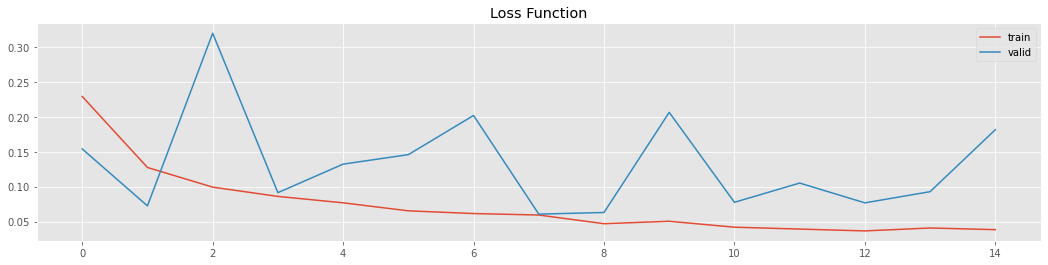

In [40]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

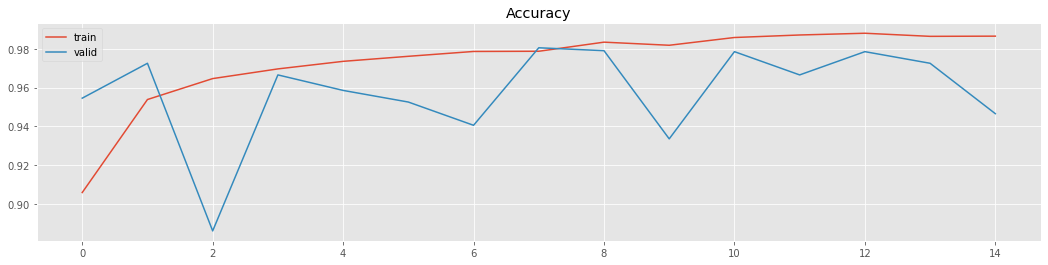

In [41]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

model evaluation

In [42]:
#load the best model
model_.load_weights('weights.best.inc.male2.hdf5')

In [43]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 97.4500%
f1_score: 0.9742813918305597


In [44]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
   
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    
##this part is extra#####
def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [45]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result


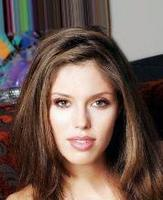


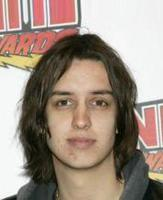

In [46]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(2)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])